# **Fraud Detection Model Based on Stripe Radar**

Stripe Radar provides business with the capability to utilize their ML models that detect fraud, mainly transaction fraud in real time when using Stripe as a payment processor. Stripe has evolved to utiltize over 1000 features to classify a transaction  as fraudulent or not. Stripe's model has evolved significiantly over the years:  Stripe initially used an XGBoost, which then evolved into and XGBoost + DNN(Deep Neural Network) Ensemble from which the XGBoost component was later removed. In this file we attempt to replicate Stripe radar and come up with an ML model that does an accurate job of catching fraud.

# Initial EDA

In [ ]:
# Importing relevant libraries for decision trees, box plots, heatmap, and simple statistical techniques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
# Creating a data frame using the imported CSV file
# Assuming the CSV file is named 'Bank_Fraud_Dataset.csv' and is in the current working directory
df = pd.read_csv('Bank_Fraud_Dataset.csv')

print(df.head()) # Display the first few rows of the DataFrame

   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  \
0              102.453711           AA          1059  ...   
1           

In [ ]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        200000 non-null  int64  
 1   income                            200000 non-null  float64
 2   name_email_similarity             200000 non-null  float64
 3   prev_address_months_count         200000 non-null  int64  
 4   current_address_months_count      200000 non-null  int64  
 5   customer_age                      200000 non-null  int64  
 6   days_since_request                200000 non-null  float64
 7   intended_balcon_amount            200000 non-null  float64
 8   payment_type                      200000 non-null  object 
 9   zip_count_4w                      200000 non-null  int64  
 10  velocity_6h                       200000 non-null  float64
 11  velocity_24h                      200000 non-null  f

In [ ]:
from sklearn.impute import SimpleImputer

# Assuming 'df' is your original DataFrame with potential missing values

# Identify numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

# Identify numerical columns with missing values
numerical_cols_with_missing = numerical_cols[df[numerical_cols].isnull().any()]

# Store original dtypes for these specific columns
original_dtypes_missing = df[numerical_cols_with_missing].dtypes

# Check if there are any numerical columns with missing values
if len(numerical_cols_with_missing) > 0:
    # Create a SimpleImputer instance with 'median' strategy
    imputer = SimpleImputer(strategy='median')

    # Fit and transform only the numerical columns with missing values
    df_numerical_imputed_array = imputer.fit_transform(df[numerical_cols_with_missing])

    # Create a new DataFrame from the imputed array
    df_numerical_imputed_subset = pd.DataFrame(df_numerical_imputed_array, columns=numerical_cols_with_missing)

    # Convert imputed columns back to their original integer dtype where appropriate
    for col in numerical_cols_with_missing:
        if original_dtypes_missing[col] == np.int64 or original_dtypes_missing[col] == np.int32:
            if np.all(np.isclose(df_numerical_imputed_subset[col], np.floor(df_numerical_imputed_subset[col]))):
                 df_numerical_imputed_subset[col] = df_numerical_imputed_subset[col].astype(original_dtypes_missing[col])
            # If the imputed median has a fractional part, keep as float (no else needed as it's already float)

    # Update the original DataFrame with the imputed values
    # This is more memory efficient than creating a new DataFrame from scratch
    df_no_missing = df.copy() # Create a copy to avoid modifying the original 'df' in place
    df_no_missing[numerical_cols_with_missing] = df_numerical_imputed_subset
else:
    # If no numerical columns have missing values, just copy the original DataFrame
    df_no_missing = df.copy()


# Display concise summary of the imputed DataFrame
df_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        200000 non-null  int64  
 1   income                            200000 non-null  float64
 2   name_email_similarity             200000 non-null  float64
 3   prev_address_months_count         200000 non-null  int64  
 4   current_address_months_count      200000 non-null  int64  
 5   customer_age                      200000 non-null  int64  
 6   days_since_request                200000 non-null  float64
 7   intended_balcon_amount            200000 non-null  float64
 8   payment_type                      200000 non-null  object 
 9   zip_count_4w                      200000 non-null  int64  
 10  velocity_6h                       200000 non-null  float64
 11  velocity_24h                      200000 non-null  f

In [ ]:
# Looking for Duplicate Rows
duplicate_rows_df=df_no_missing[df_no_missing.duplicated()]
print("No. of Duplicate rows", duplicate_rows_df.shape)
df_no_missing.duplicated().sum()

No. of Duplicate rows (0, 33)


0

In [ ]:
# Generate descriptive statistics of the numerical columns in the DataFrame
df_no_missing.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,ID
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.000000,200000.000000
mean,0.010630,0.537184,0.496496,16.557660,90.367210,33.392550,9.422854e-01,9.647162,2003.240790,7225.366960,...,11.686195,0.183595,567.759700,0.033180,8.189715,0.648550,1.028535,0.0,0.337800,100000.500000
std,0.102553,0.290785,0.286043,44.278904,91.934497,12.327525,4.707124e+00,20.696069,1263.268756,3116.262052,...,11.922711,0.387155,544.830232,0.179107,8.679465,0.477424,0.215873,0.0,0.472961,57735.171256
min,0.000000,0.100000,0.000032,-1.000000,-1.000000,10.000000,4.040000e-09,-13.202786,2.000000,-29.235883,...,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000,1.000000
25%,0.000000,0.200000,0.225106,-1.000000,22.000000,20.000000,7.039064e-03,-1.184425,1073.000000,4981.488358,...,1.000000,0.000000,200.000000,0.000000,3.469201,0.000000,1.000000,0.0,0.000000,50000.750000
50%,0.000000,0.600000,0.513060,-1.000000,53.000000,30.000000,1.489647e-02,-0.809822,1584.000000,7380.364739,...,9.000000,0.000000,200.000000,0.000000,5.341666,1.000000,1.000000,0.0,0.000000,100000.500000
75%,0.000000,0.800000,0.745551,11.000000,142.000000,40.000000,2.593825e-02,14.557498,2693.250000,9051.834391,...,25.000000,0.000000,1000.000000,0.000000,9.212150,1.000000,1.000000,0.0,1.000000,150000.250000
max,1.000000,0.900000,0.999999,367.000000,425.000000,90.000000,7.658148e+01,112.956928,6700.000000,16715.565400,...,32.000000,1.000000,2100.000000,1.000000,83.213536,1.000000,2.000000,0.0,1.000000,200000.000000


In [ ]:
# Create a copy to avoid modifying the original DataFrame
df_processed = df_no_missing.copy()

# Drop the 'ID' column
df_processed = df_processed.drop('ID', axis=1)

print(df_processed.head())

   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ..

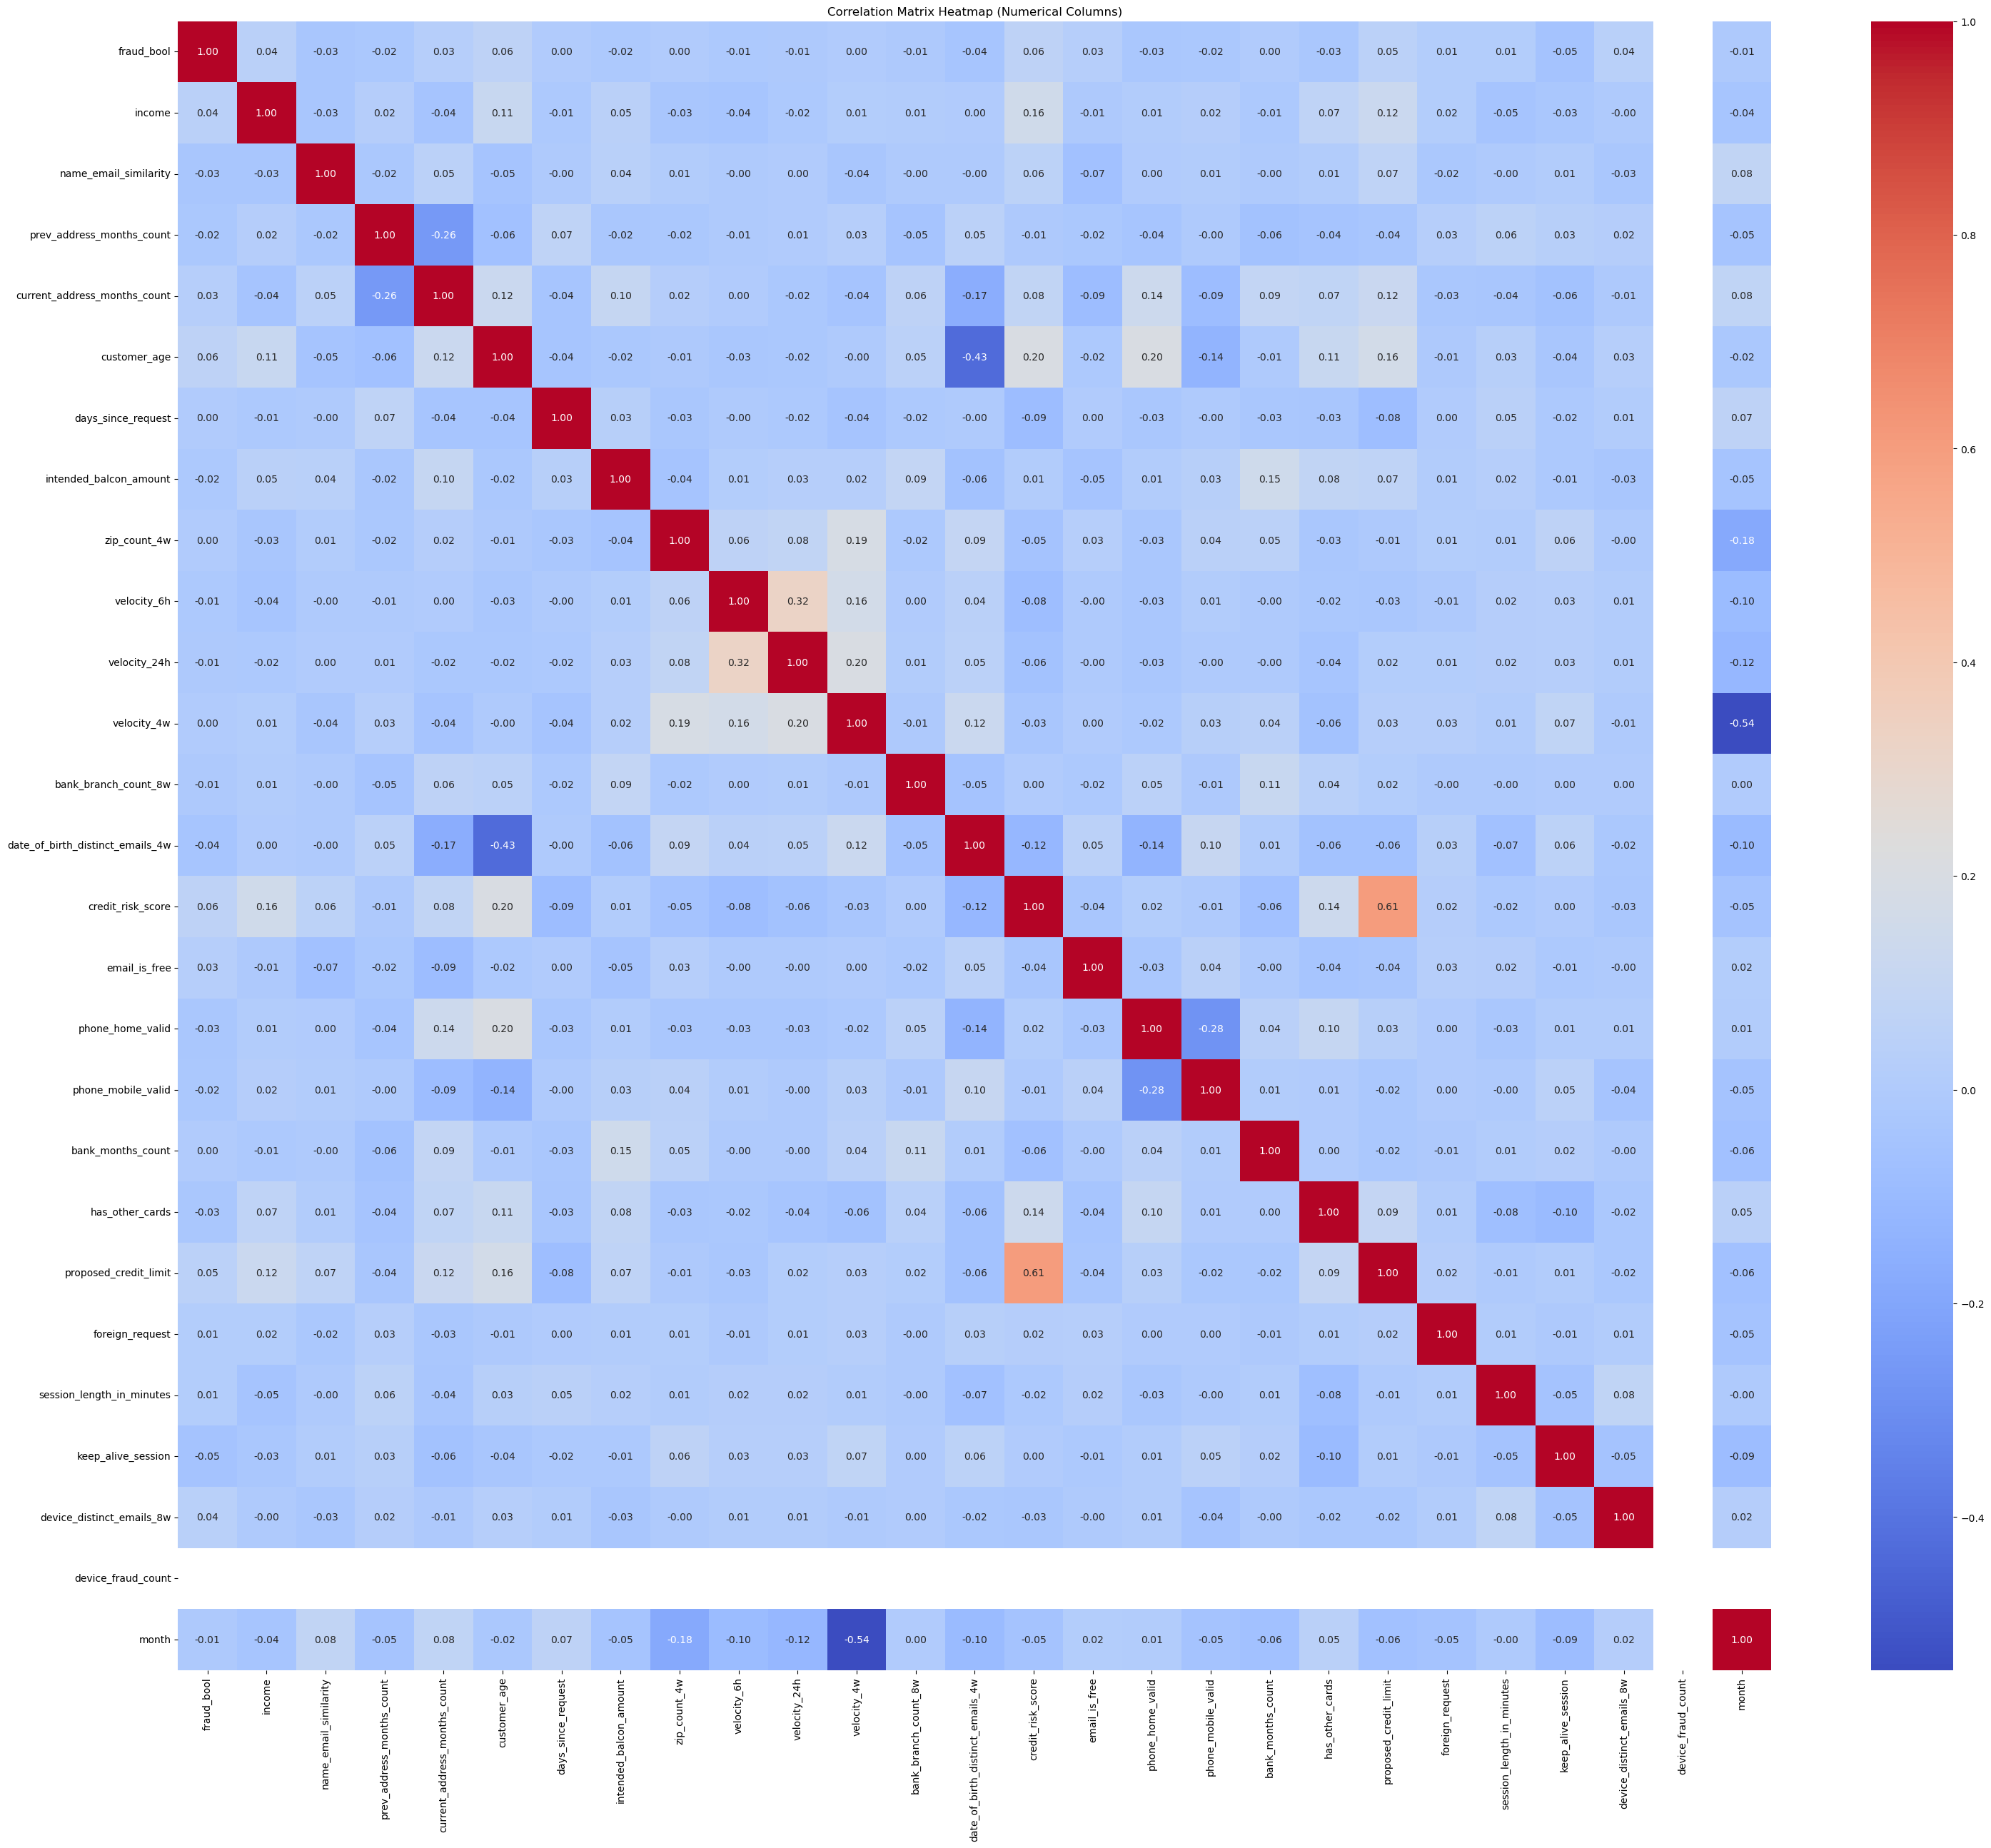

In [ ]:
# Creating a heat map of the correlation matrix for the data frame

# Select only numerical columns
numerical_df_processed = df_processed.select_dtypes(include=np.number)

# Calculate the correlation matrix for numerical columns only
corr_matrix = numerical_df_processed.corr()

# Create the heatmap
plt.figure(figsize=(36, 30))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap (Numerical Columns)')
plt.show()

In [ ]:
# Shows the distribution of values in the (Y) column 'fraud_bool'

print(df_processed.fraud_bool.value_counts())

fraud_bool
0    197874
1      2126
Name: count, dtype: int64


# **Best Model(According to ROC-AUC): XGB+DNN Ensemble**

XGboost annd DNN ensemble was the last model that we utilized. Before this we worked to optimize the xgboost model as well as the DNN. When we ran the ensemble for the first time we ran our optimized XGboost with a basic DNN which gave us a higher ROC-AUC score than the individual XGboost as well as the optimized DNN showing that a combination of both these worked best for our dataset.

imblearn components loaded successfully.
Dataset loaded successfully.
Original dataset shape: (200000, 33)

Starting Common Feature Engineering...
Created Ratio Features.
Created Binned Features.
Shape of X after common feature engineering: (200000, 37)

Master Train shape: (160000, 37), Master Test shape: (40000, 37)
Fraud in Master Train: 1701, Master Test: 425

--- Starting XGBoost Model Path ---
XGB Numerical Features (30): ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age']...
XGB Categorical Features (7): ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'customer_age_binned', 'credit_risk_score_binned']
Fitting GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best XGB

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,841 (77.50 KB)

 Trainable params: 19,393 (75.75 KB)

 Non-trainable params: 448 (1.75 KB)

Basic DNN Class Weights: {0: 0.5053735421157779, 1: 47.0242468772961}
Training Basic DNN model...
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - auc_pr: 0.0122 - auc_roc: 0.5189 - loss: 0.9038 - val_auc_pr: 0.0272 - val_auc_roc: 0.6975 - val_loss: 0.7060 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc_pr: 0.0228 - auc_roc: 0.6593 - loss: 0.7243 - val_auc_pr: 0.0423 - val_auc_roc: 0.7648 - val_loss: 0.6781 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - auc_pr: 0.0288 - auc_roc: 0.7273 - loss: 0.6472 - val_auc_pr: 0.0515 - val_auc_roc: 0.7927 - val_loss: 0.6282 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc_pr: 0.0368 - auc_roc: 0.7473 - loss: 0.6249 - val_auc_pr: 0.0604 - val_auc_roc: 0.8107 - val_loss: 0.5902 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc_pr: 0.0414 - auc_roc: 0.7535 - loss: 0.6156 - val_auc_pr: 0.0688 - val_auc_r

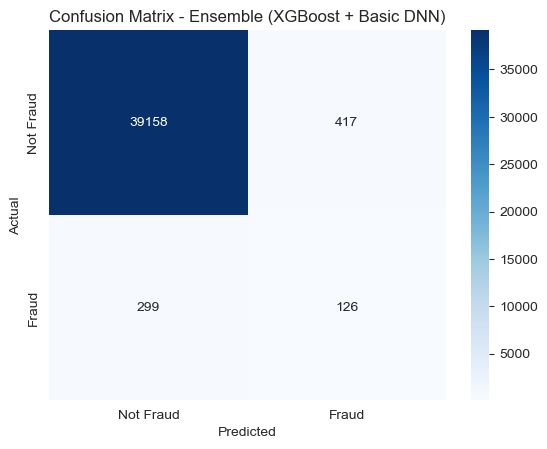

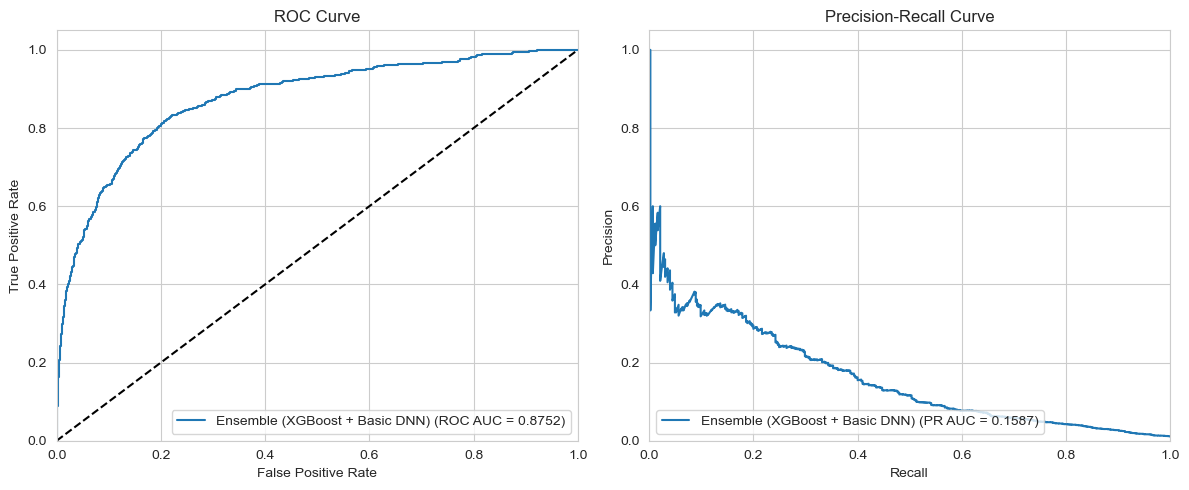


Summary for Ensemble (XGBoost + Basic DNN):
  Final ROC AUC Score: 0.8752
  Final PR AUC Score: 0.1587
----------------------------------------

--- End of Ensemble Script ---


In [ ]:
#Ensemble
import pandas as pd #best Ensemble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures # LabelEncoder removed as not used for basic DNN
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, roc_curve, f1_score
)

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential # Using Sequential for basic DNN
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization # Added Input here
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.utils import plot_model # plot_model might be less informative for simple Sequential


# Attempt to import imblearn components
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.under_sampling import RandomUnderSampler
    IMBLEARN_AVAILABLE = True
    print("imblearn components loaded successfully.")
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("CRITICAL Warning: imbalanced-learn library not found. Undersampling for XGBoost will be skipped if not available.")

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# --- Configuration ---
SEED = 42
np.random.seed(SEED)
if 'tf' in globals():
    tf.random.set_seed(SEED)

TARGET_COL = 'fraud_bool'
ID_COL = 'ID'
MASTER_TEST_SIZE = 0.2
DNN_VAL_SIZE_FROM_MASTER_TRAIN = 0.2
EPSILON = 1e-6
FILE_PATH = 'Bank_Fraud_Dataset.csv'

# --- Utility Functions ---
def sanitize_feature_name(name):
    name_str = str(name)
    sanitized_name = re.sub(r"[\[\]<]", "_", name_str)
    return sanitized_name

def plot_roc_pr_curves(y_true, y_pred_proba, model_name):
    plt.figure(figsize=(12, 5))
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc_val = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (ROC AUC = {roc_auc_val:.4f})')
    plt.plot([0, 1], [0, 1], 'k--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend(loc="lower right")
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc_val = auc(recall, precision)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name} (PR AUC = {pr_auc_val:.4f})')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(loc="lower left")
    plt.tight_layout(); plt.show()

def display_evaluation(y_true, y_pred_proba, model_name):
    print(f"\n--- Evaluation for: {model_name} ---")
    roc_auc_val = roc_auc_score(y_true, y_pred_proba)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
    pr_auc_val = auc(recall, precision)

    # Explicitly print ROC AUC and PR AUC at the beginning of the evaluation block
    print(f"ROC AUC Score: {roc_auc_val:.4f}")
    print(f"PR AUC Score: {pr_auc_val:.4f}")

    f1_scores = (2 * precision * recall) / (precision + recall + EPSILON)
    valid_f1_scores = f1_scores[:-1] if len(f1_scores) > len(thresholds_pr) else f1_scores
    if len(valid_f1_scores) == 0:
        optimal_idx = 0
        optimal_threshold = 0.5
    else:
        optimal_idx = np.argmax(valid_f1_scores)
        optimal_threshold = thresholds_pr[optimal_idx] if len(thresholds_pr) > optimal_idx else 0.5

    print(f"Optimal threshold based on F1 for PR curve: {optimal_threshold:.4f}")
    y_pred_class = (y_pred_proba >= optimal_threshold).astype(int)
    print("\nClassification Report (using optimal threshold):")
    print(classification_report(y_true, y_pred_class, target_names=['Not Fraud', 'Fraud'], zero_division=0))
    cm = confusion_matrix(y_true, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix - {model_name}'); plt.show()
    plot_roc_pr_curves(y_true, y_pred_proba, model_name)

    # Added clearer summary print for ROC AUC at the end of this function's output
    print(f"\nSummary for {model_name}:")
    print(f"  Final ROC AUC Score: {roc_auc_val:.4f}")
    print(f"  Final PR AUC Score: {pr_auc_val:.4f}")
    print("-" * 40)


# --- Load Data ---
try:
    df = pd.read_csv(FILE_PATH)
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load the dataset from '{FILE_PATH}'. Error: {e}")
    raise

# --- Initial Data Cleaning ---
if ID_COL in df.columns: df = df.drop(ID_COL, axis=1)
if TARGET_COL not in df.columns: raise ValueError(f"Target column '{TARGET_COL}' not found.")

# --- Common Feature Engineering ---
print("\nStarting Common Feature Engineering...")
X_fe = df.drop(TARGET_COL, axis=1).copy()
y_fe = df[TARGET_COL].copy()

# Impute NaNs before feature engineering
for col in X_fe.columns:
    if X_fe[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X_fe[col]):
            X_fe[col] = X_fe[col].fillna(X_fe[col].median())
        else:
            X_fe[col] = X_fe[col].fillna(X_fe[col].mode()[0])

cols_with_neg_one = ['prev_address_months_count', 'bank_months_count']
for col in cols_with_neg_one:
    if col in X_fe.columns: X_fe[col] = X_fe[col].replace(-1, 0)

# Ratio Features. We do feature engineering here by making new deatures from our old ones. Some of these include income:age ratio, and income:balance ratio
if 'income' in X_fe.columns and 'customer_age' in X_fe.columns: X_fe['income_to_age_ratio'] = X_fe['income'] / (X_fe['customer_age'] + EPSILON)
if 'intended_balcon_amount' in X_fe.columns and 'income' in X_fe.columns:
    X_fe['income_safe_for_ratio'] = X_fe['income'].apply(lambda x: x if x > 0 else EPSILON)
    X_fe['intended_balcon_to_income_ratio'] = X_fe['intended_balcon_amount'] / X_fe['income_safe_for_ratio']
    X_fe = X_fe.drop(columns=['income_safe_for_ratio'])
if 'velocity_6h' in X_fe.columns and 'velocity_24h' in X_fe.columns: X_fe['velocity_6h_to_24h_ratio'] = X_fe['velocity_6h'] / (X_fe['velocity_24h'] + EPSILON)
if 'prev_address_months_count' in X_fe.columns and 'current_address_months_count' in X_fe.columns: X_fe['prev_addr_to_curr_addr_ratio'] = X_fe['prev_address_months_count'] / (X_fe['current_address_months_count'] + EPSILON)
print("Created Ratio Features.")

# Binning Numerical Features
if 'customer_age' in X_fe.columns:
    age_bins = [0, 18, 30, 45, 60, 120]; age_labels = ['Age_less_18', 'Age_18-30', 'Age_31-45', 'Age_46-60', 'Age_60_plus']
    X_fe['customer_age_binned'] = pd.cut(X_fe['customer_age'], bins=age_bins, labels=[sanitize_feature_name(l) for l in age_labels], right=False)
if 'credit_risk_score' in X_fe.columns:
    max_score = X_fe['credit_risk_score'].max(); min_score_val = X_fe['credit_risk_score'].min()
    score_bins = [min_score_val - EPSILON if min_score_val > 0 else 0, 100, 200, 300, max_score + EPSILON]
    score_labels = ['Risk_VeryLow', 'Risk_Low', 'Risk_Medium', 'Risk_High']
    unique_bins = sorted(list(set(b for b in score_bins if b <= max_score + EPSILON)))
    if unique_bins[0] < min_score_val and min_score_val > 0: unique_bins[0] = min_score_val
    elif unique_bins[0] < 0 and min_score_val == 0: unique_bins[0] = 0
    final_labels = [sanitize_feature_name(l) for l in score_labels]
    if len(unique_bins) < 2: print(f"Warning: Not enough unique bins for credit_risk_score. Skipping binning.")
    else:
        if len(unique_bins) - 1 < len(final_labels): final_labels = final_labels[:len(unique_bins)-1]
        X_fe['credit_risk_score_binned'] = pd.cut(X_fe['credit_risk_score'], bins=unique_bins, labels=final_labels, right=False, include_lowest=True)
print("Created Binned Features.")
print(f"Shape of X after common feature engineering: {X_fe.shape}")


# --- Master Data Split ---
X_master_train, X_master_test, y_master_train, y_master_test = train_test_split(
    X_fe, y_fe, test_size=MASTER_TEST_SIZE, random_state=SEED, stratify=y_fe
)
print(f"\nMaster Train shape: {X_master_train.shape}, Master Test shape: {X_master_test.shape}")
print(f"Fraud in Master Train: {y_master_train.sum()}, Master Test: {y_master_test.sum()}")


# --- XGBoost Model Path ---
print("\n--- Starting XGBoost Model Path ---")
y_pred_proba_xgb_test = np.zeros_like(y_master_test, dtype=float) # Initialize placeholder

if not IMBLEARN_AVAILABLE:
    print("XGBoost with undersampling cannot proceed as imblearn is not available. XGBoost predictions will be zeros.")
else:
    xgb_categorical_features_def = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
    if 'customer_age_binned' in X_master_train.columns: xgb_categorical_features_def.append('customer_age_binned')
    if 'credit_risk_score_binned' in X_master_train.columns: xgb_categorical_features_def.append('credit_risk_score_binned')

    xgb_final_categorical_features = [col for col in xgb_categorical_features_def if col in X_master_train.columns and (X_master_train[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X_master_train[col]))]
    xgb_final_numerical_features = [col for col in X_master_train.columns if col not in xgb_final_categorical_features and pd.api.types.is_numeric_dtype(X_master_train[col])]

    print(f"XGB Numerical Features ({len(xgb_final_numerical_features)}): {xgb_final_numerical_features[:5]}...")
    print(f"XGB Categorical Features ({len(xgb_final_categorical_features)}): {xgb_final_categorical_features}")

    xgb_numerical_transformer = StandardScaler() if xgb_final_numerical_features else 'drop'
    xgb_categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first') if xgb_final_categorical_features else 'drop'

    xgb_transformers_list = []
    if xgb_final_numerical_features and xgb_numerical_transformer != 'drop':
        xgb_transformers_list.append(('num', xgb_numerical_transformer, xgb_final_numerical_features))
    if xgb_final_categorical_features and xgb_categorical_transformer != 'drop':
        xgb_transformers_list.append(('cat', xgb_categorical_transformer, xgb_final_categorical_features))

    xgb_preprocessor = ColumnTransformer(transformers=xgb_transformers_list, remainder='passthrough') if xgb_transformers_list else ColumnTransformer(transformers=[('empty', 'passthrough', X_master_train.columns.tolist())])

    xgb_pipeline_rus = ImbPipeline([
        ('preprocessor', xgb_preprocessor),
        ('undersampler', RandomUnderSampler(random_state=SEED)),
        ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=SEED))
    ])

    param_grid_xgb = {
        'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.05, 0.1], 'classifier__subsample': [0.8],
        'classifier__colsample_bytree': [0.8]
    }
    cv_strategy_xgb = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    grid_search_xgb = GridSearchCV(
        estimator=xgb_pipeline_rus, param_grid=param_grid_xgb, scoring='roc_auc',
        cv=cv_strategy_xgb, verbose=1, n_jobs=-1
    )
    print("Fitting GridSearchCV for XGBoost...")
    grid_search_xgb.fit(X_master_train, y_master_train)
    print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
    print(f"Best XGBoost CV ROC AUC: {grid_search_xgb.best_score_:.4f}")
    best_xgb_model = grid_search_xgb.best_estimator_
    y_pred_proba_xgb_test = best_xgb_model.predict_proba(X_master_test)[:, 1]


# --- Basic DNN Model Path ---
print("\n--- Starting Basic DNN Model Path ---")
y_pred_proba_dnn_test = np.zeros_like(y_master_test, dtype=float) # Initialize placeholder

# Define feature sets for DNN preprocessor (based on X_master_train columns)
# For a basic DNN, we'll one-hot encode all categoricals and scale all numericals from X_fe
dnn_all_categorical_features = [col for col in X_master_train.columns if X_master_train[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X_master_train[col])]
# Ensure binned features are treated as categorical for OHE
if 'customer_age_binned' in X_master_train.columns and 'customer_age_binned' not in dnn_all_categorical_features:
    dnn_all_categorical_features.append('customer_age_binned')
if 'credit_risk_score_binned' in X_master_train.columns and 'credit_risk_score_binned' not in dnn_all_categorical_features:
    dnn_all_categorical_features.append('credit_risk_score_binned')
dnn_all_categorical_features = list(set(dnn_all_categorical_features)) # Unique list

dnn_all_numerical_features = [col for col in X_master_train.columns if col not in dnn_all_categorical_features and pd.api.types.is_numeric_dtype(X_master_train[col])]

print(f"DNN Numerical Features for Preprocessing ({len(dnn_all_numerical_features)}): {dnn_all_numerical_features[:5]}...")
print(f"DNN Categorical Features for Preprocessing ({len(dnn_all_categorical_features)}): {dnn_all_categorical_features}")

dnn_numerical_transformer = StandardScaler() if dnn_all_numerical_features else 'drop'
dnn_categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) if dnn_all_categorical_features else 'drop' # No drop='first' for basic DNN usually

dnn_transformers_list = []
if dnn_all_numerical_features and dnn_numerical_transformer != 'drop':
    dnn_transformers_list.append(('num', dnn_numerical_transformer, dnn_all_numerical_features))
if dnn_all_categorical_features and dnn_categorical_transformer != 'drop':
    dnn_transformers_list.append(('cat', dnn_categorical_transformer, dnn_all_categorical_features))

if not dnn_transformers_list:
    print("Error: No features identified for DNN preprocessing. DNN predictions will be zeros.")
else:
    dnn_preprocessor = ColumnTransformer(transformers=dnn_transformers_list, remainder='passthrough')

    # Split master training set for DNN's own training and validation
    X_dnn_train_for_dnn_prep, X_dnn_val_for_dnn_prep, y_dnn_train_for_dnn_prep, y_dnn_val_for_dnn_prep = train_test_split(
        X_master_train, y_master_train, test_size=DNN_VAL_SIZE_FROM_MASTER_TRAIN,
        random_state=SEED, stratify=y_master_train
    )

    print("Preprocessing data for Basic DNN...")
    X_dnn_train_processed = dnn_preprocessor.fit_transform(X_dnn_train_for_dnn_prep)
    X_dnn_val_processed = dnn_preprocessor.transform(X_dnn_val_for_dnn_prep)
    X_dnn_master_test_processed = dnn_preprocessor.transform(X_master_test) # Preprocess the master test set

    print(f"Shape of processed DNN training data: {X_dnn_train_processed.shape}")

    # Build Basic DNN Architecture
    basic_dnn_model = Sequential([
        Input(shape=(X_dnn_train_processed.shape[1],)), # Input layer based on processed data shape
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'), # Added one more smaller dense layer
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    basic_dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            loss='binary_crossentropy',
                            metrics=[tf.keras.metrics.AUC(name='auc_roc'), tf.keras.metrics.AUC(name='auc_pr', curve='PR')])
    basic_dnn_model.summary()

    # Class Weights for DNN
    neg_dnn, pos_dnn = np.bincount(y_dnn_train_for_dnn_prep)
    total_dnn = neg_dnn + pos_dnn
    dnn_class_weights = {
        0: (1 / neg_dnn) * (total_dnn / 2.0) if neg_dnn > 0 else 1,
        1: (1 / pos_dnn) * (total_dnn / 2.0) if pos_dnn > 0 else 1
    }
    print(f"Basic DNN Class Weights: {dnn_class_weights}")

    early_stopping_dnn = EarlyStopping(monitor='val_auc_pr', patience=10, mode='max', restore_best_weights=True, verbose=1)
    reduce_lr_dnn = ReduceLROnPlateau(monitor='val_auc_pr', factor=0.2, patience=5, min_lr=1e-6, mode='max', verbose=1)

    print("Training Basic DNN model...")
    history_basic_dnn = basic_dnn_model.fit(
        X_dnn_train_processed, y_dnn_train_for_dnn_prep,
        epochs=50, # Increased epochs slightly
        batch_size=256,
        validation_data=(X_dnn_val_processed, y_dnn_val_for_dnn_prep),
        callbacks=[early_stopping_dnn, reduce_lr_dnn],
        class_weight=dnn_class_weights,
        verbose=1
    )
    y_pred_proba_dnn_test = basic_dnn_model.predict(X_dnn_master_test_processed).ravel()
    # display_evaluation(y_master_test, y_pred_proba_dnn_test, "DNN (Basic Scratch)") # Optional


# --- Ensemble Predictions ---
print("\n--- Ensembling Predictions ---")
if y_pred_proba_xgb_test is None or y_pred_proba_dnn_test is None or \
   (isinstance(y_pred_proba_xgb_test, np.ndarray) and y_pred_proba_xgb_test.size == 0) or \
   (isinstance(y_pred_proba_dnn_test, np.ndarray) and y_pred_proba_dnn_test.size == 0):
    print("Error: One or both models did not produce valid predictions. Cannot ensemble.")
elif len(y_pred_proba_xgb_test) != len(y_master_test) or len(y_pred_proba_dnn_test) != len(y_master_test):
    print(f"Error: Prediction length mismatch. XGB: {len(y_pred_proba_xgb_test)}, DNN: {len(y_pred_proba_dnn_test)}, Test: {len(y_master_test)}")
else:
    y_pred_proba_ensemble_test = (y_pred_proba_xgb_test + y_pred_proba_dnn_test) / 2.0
    print("Ensembled predictions using simple averaging.")
    display_evaluation(y_master_test, y_pred_proba_ensemble_test, "Ensemble (XGBoost + Basic DNN)")

print("\n--- End of Ensemble Script ---")

# **Model 2: DNN**

## **Imports and Initial Setup**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, roc_curve, f1_score, precision_score, recall_score
)
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Flatten, Dense, Dropout, BatchNormalization,
    concatenate, Activation
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import warnings
import os
import random
import time

warnings.filterwarnings('ignore')

# --- Configuration & Reproducibility ---
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")

file_path = 'Bank_Fraud_Dataset.csv'

TensorFlow Version: 2.19.0


In [ ]:
# --- Global Parameters ---
TARGET_COL = 'fraud_bool'
ID_COL = 'ID'
TEST_SIZE = 0.2
VAL_SIZE = 0.2 # Validation size from the training set

## **Data Loading and Initial Inspection**

In [ ]:
print("\n--- Loading Data ---")
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print(f"ERROR: File not found at {file_path}. Please upload or adjust the path.")
    exit()


--- Loading Data ---
Dataset loaded successfully. Shape: (200000, 33)
   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  \
0 

## **EDA and Preprocessing**

**Before we can feed our data to the fraud detection model, it needs to be cleaned and prepared. This involves:**

**Understanding Fraud Rate:** We check what percentage of transactions in our dataset are fraudulent. This is important because fraud is usually rare, and our model needs to be good at finding these rare cases.

**Removing Useless Information:** The ID column is removed because unique identifiers usually don't help predict fraud.

**Sorting Features:** We look at each column (feature) and decide if it contains numbers (numerical) or categories (categorical, like 'payment_type' or 'device_os'). This is because our model handles these two types of data differently.

**Handling Missing Data:** If any cells in our table are empty (missing values), we fill them in: numerical missing values are replaced with the median (middle value) of that column, and categorical missing values are replaced with the mode (most common value).

**Standardizing Categorical Data:** All categorical features are converted to text (string type) to ensure they are handled consistently in the next steps.

In [ ]:
print("\n--- EDA & Preprocessing ---")
print(f"\nTarget variable distribution:\n{df[TARGET_COL].value_counts(normalize=True)}")

# Drop ID column for modeling
if ID_COL in df.columns:
    df_model = df.drop(columns=[ID_COL])
else:
    df_model = df.copy()
    print(f"Warning: ID column '{ID_COL}' not found.")

categorical_features = []
numerical_features = []

for col in df_model.columns:
    if col == TARGET_COL:
        continue
    if df_model[col].dtype == 'object':
        categorical_features.append(col)
    elif df_model[col].nunique() < 20 and df_model[col].dtype != 'float':
        if df_model[col].nunique() > 2:
             categorical_features.append(col)
        else:
             numerical_features.append(col)
    else:
        numerical_features.append(col)

print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

for col in numerical_features:
    if df_model[col].isnull().any():
        median_val = df_model[col].median()
        df_model[col] = df_model[col].fillna(median_val)
        # print(f"Filled NaNs in numerical column '{col}' with median: {median_val}") # Keep output clean

for col in categorical_features:
    if df_model[col].isnull().any():
        mode_val = df_model[col].mode()[0]
        df_model[col] = df_model[col].fillna(mode_val)
        # print(f"Filled NaNs in categorical column '{col}' with mode: {mode_val}") # Keep output clean
    df_model[col] = df_model[col].astype(str)


--- EDA & Preprocessing ---

Target variable distribution:
fraud_bool
0    0.98937
1    0.01063
Name: proportion, dtype: float64

Identified Numerical Features: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_fraud_count', 'month']
Identified Categorical Features: ['customer_age', 'payment_type', 'employment_status', 'housing_status', 'proposed_credit_limit', 'source', 'device_os', 'device_distinct_emails_8w']


## **Data Splitting**

**Features (X) and Target (y):** We separate our data table into two parts: the features (all columns except the fraud label) which the model will use to make predictions, and the target (the fraud_bool column) which tells us if a transaction was actually fraudulent.

**Training Set:** This is the largest part of the data (about 64% in our case) and is used to "teach" or train our fraud detection model. The model learns patterns from this data.

**Validation Set:** A smaller portion (about 16%) is set aside as a validation set. During training, we use this set to check how well the model is learning and to make adjustments (like stopping training early if it's not improving). This helps prevent the model from just memorizing the training data.

**Test Set:** Another portion (20%) is kept completely separate as the test set. After the model is fully trained, we use this "unseen" data to get a final, unbiased measure of how well it can predict fraud on new transactions.

**Stratified Splitting:** When dividing the data, we ensure that the proportion of fraudulent to non-fraudulent transactions is the same in all three sets (train, validation, test) as it was in the original dataset. This is very important when dealing with imbalanced data like fraud.

In [ ]:
print("\n--- Splitting Data ---")
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

if y.dtype != 'int':
    y = y.replace([np.inf, -np.inf], np.nan)
    y = y.fillna(y.mode()[0]).astype(int)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=SEED, stratify=y_train_full
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Fraud cases in train: {y_train.sum()}, val: {y_val.sum()}, test: {y_test.sum()}")


--- Splitting Data ---
Train shape: (128000, 31), Validation shape: (32000, 31), Test shape: (40000, 31)
Fraud cases in train: 1361, val: 340, test: 425


## **Feature Scaling and Encoding**

Numeric feature scaling done using standardscaler. Categorical feature encoding done using LabelEncoder to further make the model accurate.

In [ ]:
print("\n--- Scaling and Encoding ---")

if numerical_features:
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_val_num_scaled = scaler.transform(X_val[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])
else:
    X_train_num_scaled, X_val_num_scaled, X_test_num_scaled = None, None, None

label_encoders = {}
X_train_cat_encoded_list = [] # Use list for Keras multi-input
X_val_cat_encoded_list = []
X_test_cat_encoded_list = []
cat_emb_input_dims = []

if categorical_features:
    for i, col in enumerate(categorical_features):
        # print(f"Processing categorical feature: {col}") # Keep output clean
        combined_categories = pd.concat([X_train[col], X_val[col], X_test[col]], axis=0).astype(str).unique()

        le = LabelEncoder()
        le.fit(combined_categories)

        X_train_cat_encoded_list.append(le.transform(X_train[col].astype(str)))
        X_val_cat_encoded_list.append(le.transform(X_val[col].astype(str)))
        X_test_cat_encoded_list.append(le.transform(X_test[col].astype(str)))

        label_encoders[col] = le
        cat_emb_input_dims.append(len(le.classes_))
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
    X_val_num_scaled = scaler.transform(X_val[numerical_features])
    X_test_num_scaled = scaler.transform(X_test[numerical_features])
else:
    X_train_num_scaled, X_val_num_scaled, X_test_num_scaled = None, None, None

label_encoders = {}
X_train_cat_encoded_list = [] # Use list for Keras multi-input
X_val_cat_encoded_list = []
X_test_cat_encoded_list = []
cat_emb_input_dims = []

if categorical_features:
    for i, col in enumerate(categorical_features):
        # print(f"Processing categorical feature: {col}") # Keep output clean
        combined_categories = pd.concat([X_train[col], X_val[col], X_test[col]], axis=0).astype(str).unique()

        le = LabelEncoder()
        le.fit(combined_categories)

        X_train_cat_encoded_list.append(le.transform(X_train[col].astype(str)))
        X_val_cat_encoded_list.append(le.transform(X_val[col].astype(str)))
        X_test_cat_encoded_list.append(le.transform(X_test[col].astype(str)))

        label_encoders[col] = le
        cat_emb_input_dims.append(len(le.classes_))


--- Scaling and Encoding ---


## **DNN Model Architecture Definition**

**Multi-Input Design:** Our model is designed to handle numerical and categorical features separately at first.

**Numerical Inputs:** Scaled numerical features go into one input path.
Categorical Inputs & Embeddings: Each categorized feature (now represented by numbers) goes into its own input path. Here, a special Embedding layer is used. This layer learns to represent each category as a dense list of numbers (a vector). This is powerful because it can learn relationships between categories (e.g., certain device types might be related to similar fraud patterns). The output from each embedding is then flattened into a single list of numbers. The size of these learned vectors (embedding dimension) is set to be half the number of unique categories, up to a maximum of 50.

**Combining Features:** The processed numerical features and the flattened outputs from all the embedding layers are then combined (concatenated) into one long list of features.

**Deep Layers (Dense Layers):** This combined feature list is then passed through several layers of interconnected "neurons" (Dense layers). In our model, we have layers with 256, then 128, then 64 neurons. These layers are where the model learns complex patterns and interactions between all the input features.

**ReLU Activation:** After each dense layer, a "ReLU" activation function is applied, which helps the model learn non-linear relationships.
Batch Normalization: This technique is used after each dense layer to help stabilize and speed up the training process.

**Dropout:** This is a regularization technique. During training, it randomly "drops out" (ignores) some neurons in a layer. This prevents the model from relying too much on any single feature or neuron and helps it generalize better to new, unseen data, reducing overfitting.

**Output Layer:** The final layer has just one neuron and uses a "sigmoid" activation function. This neuron outputs a probability (a number between 0 and 1) representing the likelihood that a given transaction is fraudulent.

AUC-ROC, Precision, Accuracy, Recall and AUC-PR are metrics that have been used to evaluate model performance.

In [ ]:
print("\n--- Building DNN Model ---")

input_layers = []
embedding_output_layers = [] # Store the output of embedding/numerical layers before concatenation

if numerical_features and X_train_num_scaled is not None: # Check if X_train_num_scaled exists
    num_input = Input(shape=(X_train_num_scaled.shape[1],), name='numerical_input')
    input_layers.append(num_input)
    embedding_output_layers.append(num_input)
else:
    num_input = None

if categorical_features:
    for i, col_name in enumerate(categorical_features):
        vocab_size = cat_emb_input_dims[i]
        embedding_dim = min(50, (vocab_size // 2) if vocab_size > 1 else 1)
        if embedding_dim == 0 : embedding_dim = 1

        cat_input_layer = Input(shape=(1,), name=f'categorical_input_{col_name}')
        input_layers.append(cat_input_layer)

        embedding = Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              name=f'embedding_{col_name}')(cat_input_layer)
        flattened_embedding = Flatten(name=f'flatten_embedding_{col_name}')(embedding)
        embedding_output_layers.append(flattened_embedding)

if not embedding_output_layers: # Check if there are any layers to concatenate
    raise ValueError("No features to process! Check numerical_features and categorical_features, and their processing.")
elif len(embedding_output_layers) > 1:
    merged_features = concatenate(embedding_output_layers)
else:
    merged_features = embedding_output_layers[0]

x = Dense(256, activation='relu')(merged_features)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=input_layers, outputs=output)

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-4),
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc_roc'),
                  tf.keras.metrics.AUC(name='auc_pr', curve='PR')
              ])

model.summary()
plot_model(model, to_file='dnn_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=96)


--- Building DNN Model ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_customer… │ (None, 1, 4)      │         36 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_payment_… │ (None, 1, 2)      │         10 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_employme… │ (None, 1, 3)      │         21 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_housing_… │ (None, 1, 3)      │         21 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_proposed… │ (None, 1, 6)      │         72 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_source    │ (None, 1, 1)      │          2 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_device_os │ (None, 1, 2)      │         10 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_device_d… │ (None, 1, 2)      │          8 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 23)        │          0 │ -               

 Total params: 55,221 (215.71 KB)

 Trainable params: 54,325 (212.21 KB)

 Non-trainable params: 896 (3.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## **Class Weighting and Training Callbacks**

Using class weights to deal with class imbalance. We give fraud transaction the higher weight.

**EpochTimer Callback:** We define a small tool (a callback) to tell us how long each training cycle (epoch) takes.

### Smart Training Controls (Callbacks):
**EarlyStopping:** We tell the model to monitor its performance on the validation set. If it doesn't improve for 10 cycles (epochs) in a row, training will stop automatically, and the model will revert to its best-performing version. This saves time and prevents overfitting.

**ReduceLROnPlateau**: If the model's performance on the validation set stops improving for 3 cycles, the learning rate (how much the model adjusts itself in each step) will be automatically reduced. This helps the model make finer adjustments as it gets closer to the best solution

In [ ]:
print("\n--- Calculating Class Weights ---")
if y_train.sum() > 0 and (len(y_train) - y_train.sum()) > 0: # Ensure pos and neg counts > 0
    neg, pos = np.bincount(y_train)
    total = neg + pos
    print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100 * pos / total:.2f}% of total)\n')

    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}

    print(f'Weight for class 0 (Non-Fraud): {class_weights[0]:.2f}')
    print(f'Weight for class 1 (Fraud): {class_weights[1]:.2f}')
else:
    print("Warning: Cannot calculate class weights. Training set might be empty or contain only one class.")
    class_weights = None

class EpochTimer(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        print(f"Epoch {epoch+1} took {epoch_duration:.2f} seconds")

early_stopping = EarlyStopping(monitor='val_auc_pr',
                               patience=10,
                               mode='max',
                               restore_best_weights=True,
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc_pr',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6,
                              mode='max',
                              verbose=1)
epoch_timer = EpochTimer()


--- Calculating Class Weights ---
Examples:
    Total: 128000
    Positive: 1361 (1.06% of total)

Weight for class 0 (Non-Fraud): 0.51
Weight for class 1 (Fraud): 47.02


## **Model Training**

In [ ]:
print("\n--- Training Model ---")

X_train_inputs = []
X_val_inputs = []

if numerical_features and X_train_num_scaled is not None:
    X_train_inputs.append(X_train_num_scaled)
    X_val_inputs.append(X_val_num_scaled)
if categorical_features:
    for i in range(len(X_train_cat_encoded_list)): # Iterate using the list of encoded arrays
        X_train_inputs.append(X_train_cat_encoded_list[i])
        X_val_inputs.append(X_val_cat_encoded_list[i])

if not X_train_inputs:
    print("ERROR: No training input data prepared. Check feature identification and processing.")
else:
    EPOCHS = 75
    BATCH_SIZE = 256

    history = model.fit(
        X_train_inputs,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_inputs, y_val),
        callbacks=[early_stopping, reduce_lr, epoch_timer],
        class_weight=class_weights,
        verbose=1
    )


--- Training Model ---
Epoch 1/75
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5041 - auc_pr: 0.0148 - auc_roc: 0.5686 - loss: 0.8508 - precision: 0.0130 - recall: 0.5956Epoch 1 took 11.40 seconds
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5041 - auc_pr: 0.0148 - auc_roc: 0.5689 - loss: 0.8504 - precision: 0.0130 - recall: 0.5959 - val_accuracy: 0.5504 - val_auc_pr: 0.0425 - val_auc_roc: 0.7156 - val_loss: 0.7404 - val_precision: 0.0178 - val_recall: 0.7618 - learning_rate: 5.0000e-05
Epoch 2/75
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5297 - auc_pr: 0.0232 - auc_roc: 0.6332 - loss: 0.7785 - precision: 0.0147 - recall: 0.6423Epoch 2 took 3.41 seconds
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5298 - auc_pr: 0.0232 - auc_roc: 0.6334 - loss: 0.7783 - precision: 0.0147 - recall: 0.6427 - val_accuracy: 0.6073 - val_auc_pr: 0.0535 - val_auc_roc: 0.7502 - val_loss: 0.7045 - val_precision: 0.0206 - val_recall: 0.7735 - learning_rate: 5.0000e-0

## **Model Evaluation**


--- Evaluating Model ---


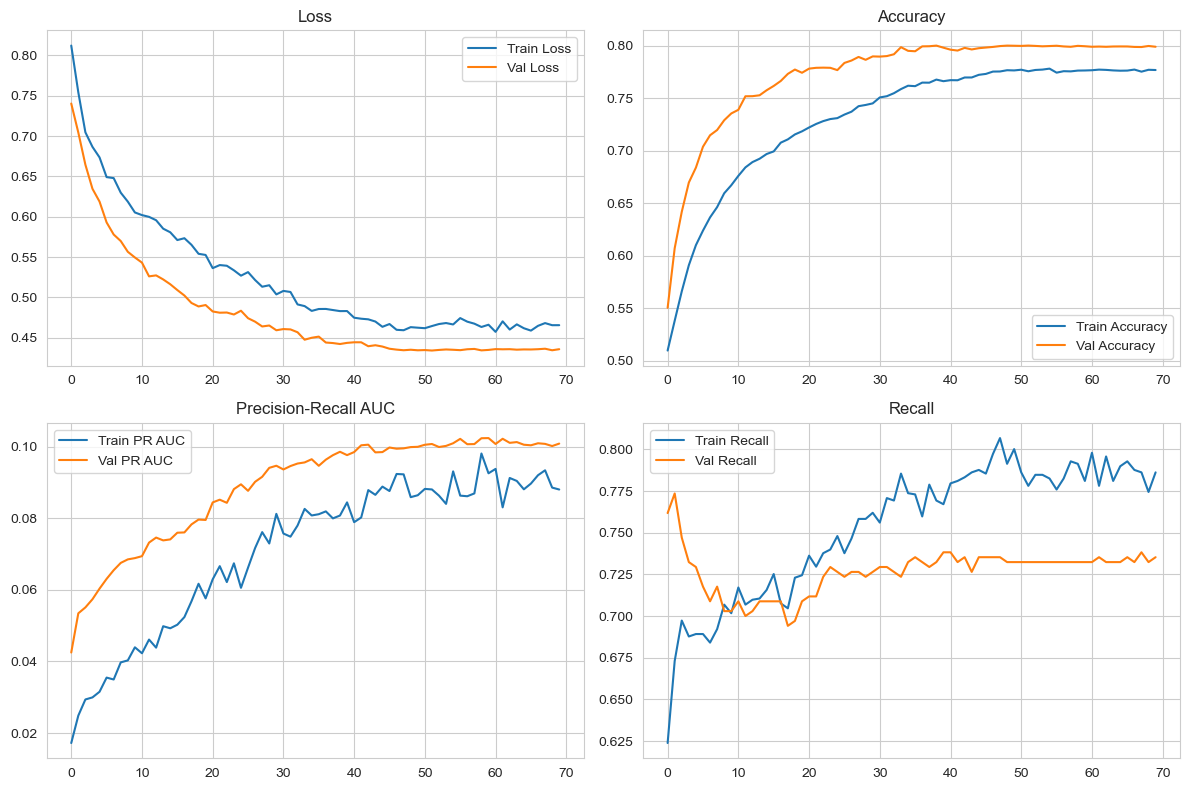


Test Set Evaluation:
  Test Loss: 0.4342
  Test Accuracy: 0.8021
  Test Precision (for fraud class): 0.0397
  Test Recall (for fraud class): 0.7600
  Test ROC AUC: 0.8582
  Test PR AUC: 0.1265
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Optimal threshold based on F1-score: 0.8895

Classification Report (Test Set with Optimal Threshold):
               precision    recall  f1-score   support

Not Fraud (0)       0.99      0.99      0.99     39575
    Fraud (1)       0.17      0.29      0.22       425

     accuracy                           0.98     40000
    macro avg       0.58      0.64      0.60     40000
 weighted avg       0.98      0.98      0.98     40000


Confusion Matrix (Test Set with Optimal Threshold):


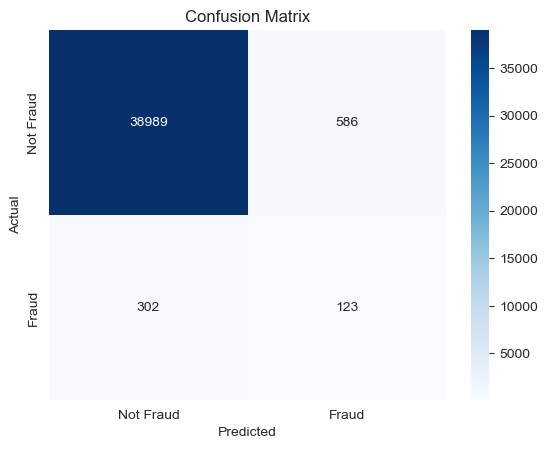

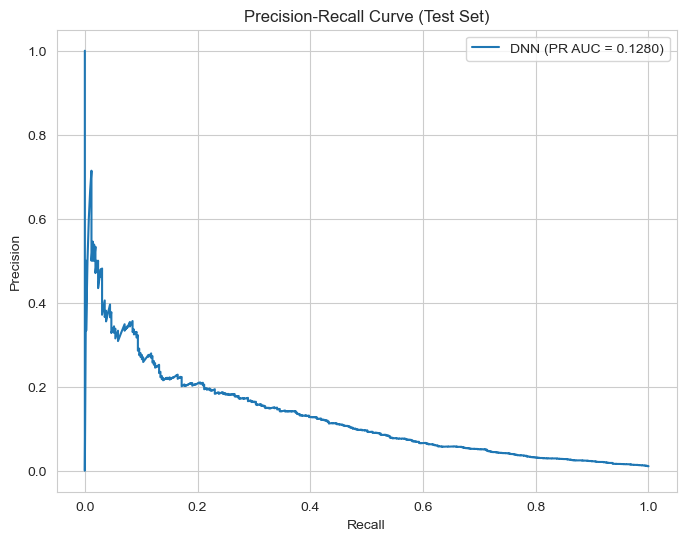

In [ ]:
print("\n--- Evaluating Model ---")

if 'history' in locals() and history is not None:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc_pr'], label='Train PR AUC')
    plt.plot(history.history['val_auc_pr'], label='Val PR AUC')
    plt.legend()
    plt.title('Precision-Recall AUC')

    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.legend()
    plt.title('Recall')
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting (model training might have been skipped or failed).")

X_test_inputs = []
if numerical_features and X_test_num_scaled is not None:
    X_test_inputs.append(X_test_num_scaled)
if categorical_features:
    for i in range(len(X_test_cat_encoded_list)): # Iterate using the list of encoded arrays
        X_test_inputs.append(X_test_cat_encoded_list[i])

if not X_test_inputs:
    print("ERROR: No test input data prepared. Evaluation cannot proceed.")
elif 'model' not in locals() or model is None:
    print("ERROR: Model is not defined. Evaluation cannot proceed.")
else:
    print("\nTest Set Evaluation:")
    test_loss, test_accuracy, test_precision, test_recall, test_auc_roc, test_auc_pr = model.evaluate(
        X_test_inputs, y_test, verbose=0
    )
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test Precision (for fraud class): {test_precision:.4f}")
    print(f"  Test Recall (for fraud class): {test_recall:.4f}")
    print(f"  Test ROC AUC: {test_auc_roc:.4f}")
    print(f"  Test PR AUC: {test_auc_pr:.4f}")

    y_pred_proba = model.predict(X_test_inputs).ravel()
    precision_pts, recall_pts, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = (2 * precision_pts * recall_pts) / (precision_pts + recall_pts + 1e-9)
    f1_scores = np.nan_to_num(f1_scores)
    if len(thresholds) == len(f1_scores):
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
    elif len(thresholds) == len(f1_scores) -1:
        optimal_idx = np.argmax(f1_scores[:-1])
        optimal_threshold = thresholds[optimal_idx]
    else:
        print("Warning: Threshold array length mismatch. Using default 0.5 threshold or first valid threshold.")
        optimal_threshold = 0.5 if len(thresholds) > 0 else 0.5 # Fallback
        if len(thresholds) > 0:
             optimal_idx = np.argmin(np.abs(thresholds - 0.5))
             optimal_threshold = thresholds[optimal_idx]
        else: # no thresholds, means no distinct probability values or single class in y_test
             optimal_idx = 0 # default
             optimal_threshold = 0.5 # default

    print(f"Optimal threshold based on F1-score: {optimal_threshold:.4f}")

    y_pred_test_optimal = (y_pred_proba >= optimal_threshold).astype(int)

    print("\nClassification Report (Test Set with Optimal Threshold):")
    print(classification_report(y_test, y_pred_test_optimal, target_names=['Not Fraud (0)', 'Fraud (1)']))

    print("\nConfusion Matrix (Test Set with Optimal Threshold):")
    cm = confusion_matrix(y_test, y_pred_test_optimal)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(8, 6))
    pr_auc = auc(recall_pts, precision_pts)
    plt.plot(recall_pts, precision_pts, label=f'DNN (PR AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Test Set)')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Model 3: XGB**

A hypertuned XGBoost using GridSearchCv. We handles class imbalance with undersampling. Feature Engineering on the categoricals was done. This model was not only quick but had the best overall scores. A decently high AUC-ROC, plus a high precision and recall.

In [ ]:
#Best xGBoost
#Undersampling with CV and feature engineering
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import numpy as np
import re # Import re for sanitization

# Attempt to import RandomUnderSampler
try:
    from imblearn.under_sampling import RandomUnderSampler
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("CRITICAL Warning: imbalanced-learn library not found. Undersampling will be skipped, which is key to this script.")
    print("To use undersampling, please install it: pip install -U imbalanced-learn")
    raise # Stop if imblearn is not available

# Define the file path for the uploaded dataset
file_path = "Bank_Fraud_Dataset.csv"
EPSILON = 1e-6 # Small constant to avoid division by zero

# Function to sanitize feature names
def sanitize_feature_name(name):
    """Converts name to string and replaces characters forbidden by XGBoost."""
    name_str = str(name)
    # Replace '[', ']', '<' with '_'
    sanitized_name = re.sub(r"[\[\]<]", "_", name_str)
    return sanitized_name

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load the dataset from '{file_path}'.")
    print(f"Error details: {e}")
    raise

# --- Initial Data Cleaning & Target Separation ---
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)
else:
    print("Warning: 'ID' column not found in the dataset.")

if 'fraud_bool' not in df.columns:
    raise ValueError("Target column 'fraud_bool' not found in the dataset.")

X_orig = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']


# --- Feature Engineering ---
print("\nStarting Feature Engineering...")
X_fe = X_orig.copy()

# 1. Ratio Features. Same as the DNN+XGB ensemble
if 'income' in X_fe.columns and 'customer_age' in X_fe.columns:
    X_fe['income_to_age_ratio'] = X_fe['income'] / (X_fe['customer_age'] + EPSILON)
    print("Created 'income_to_age_ratio' feature.")

if 'intended_balcon_amount' in X_fe.columns and 'income' in X_fe.columns:
    X_fe['income_safe_for_ratio'] = X_fe['income'].apply(lambda x: x if x > 0 else EPSILON)
    X_fe['intended_balcon_to_income_ratio'] = X_fe['intended_balcon_amount'] / X_fe['income_safe_for_ratio']
    X_fe = X_fe.drop(columns=['income_safe_for_ratio'])
    print("Created 'intended_balcon_to_income_ratio' feature.")

if 'velocity_6h' in X_fe.columns and 'velocity_24h' in X_fe.columns:
    X_fe['velocity_6h_to_24h_ratio'] = X_fe['velocity_6h'] / (X_fe['velocity_24h'] + EPSILON)
    print("Created 'velocity_6h_to_24h_ratio' feature.")

if 'prev_address_months_count' in X_fe.columns and 'current_address_months_count' in X_fe.columns:
    X_fe['prev_address_months_count_fe'] = X_fe['prev_address_months_count'].replace(-1, 0)
    X_fe['prev_addr_to_curr_addr_ratio'] = X_fe['prev_address_months_count_fe'] / (X_fe['current_address_months_count'] + EPSILON)
    X_fe = X_fe.drop(columns=['prev_address_months_count_fe'])
    print("Created 'prev_addr_to_curr_addr_ratio' feature.")

# 2. Binning Numerical Features
if 'customer_age' in X_fe.columns:
    age_bins = [0, 18, 30, 45, 60, 120]
    age_labels = ['<18', '18-30', '31-45', '46-60', '60+'] # These labels might cause issues if not sanitized later
    X_fe['customer_age_binned'] = pd.cut(X_fe['customer_age'], bins=age_bins, labels=age_labels, right=False)
    print("Created 'customer_age_binned' feature.")

if 'credit_risk_score' in X_fe.columns:
    max_score = X_fe['credit_risk_score'].max()
    # Ensure min_val is correctly handled for binning if it's the start of the first bin
    min_score_val = X_fe['credit_risk_score'].min()
    score_bins = [min_score_val - EPSILON if min_score_val > 0 else 0, 100, 200, 300, max_score + EPSILON]
    score_labels = ['VeryLow', 'Low', 'Medium', 'High']
    unique_bins = sorted(list(set(b for b in score_bins if b <= max_score + EPSILON))) # Ensure bins are progressive and within data range
    if unique_bins[0] < min_score_val: unique_bins[0] = min_score_val # Adjust first bin to actual min if needed

    final_labels = score_labels
    if len(unique_bins) < 2:
        print(f"Warning: Not enough unique bins for credit_risk_score. Min: {min_score_val}, Max: {max_score}. Skipping binning.")
    else:
        if len(unique_bins) -1 < len(score_labels):
            final_labels = score_labels[:len(unique_bins)-1]
        X_fe['credit_risk_score_binned'] = pd.cut(X_fe['credit_risk_score'], bins=unique_bins, labels=final_labels, right=False, include_lowest=True)
        print(f"Created 'credit_risk_score_binned' feature with {len(unique_bins)-1} bins.")


print(f"Shape of X after feature engineering: {X_fe.shape}")

# --- Dynamic Feature Identification after Feature Engineering ---
categorical_features_def = [
    'payment_type', 'employment_status', 'housing_status',
    'source', 'device_os'
]
if 'customer_age_binned' in X_fe.columns:
    categorical_features_def.append('customer_age_binned')
if 'credit_risk_score_binned' in X_fe.columns:
    categorical_features_def.append('credit_risk_score_binned')

categorical_features = [col for col in categorical_features_def if col in X_fe.columns and (X_fe[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X_fe[col]))]
numerical_features = [col for col in X_fe.columns if col not in categorical_features and pd.api.types.is_numeric_dtype(X_fe[col])]

print(f"\nUpdated categorical features: {categorical_features}")
print(f"Updated numerical features: {numerical_features}")

cols_with_neg_one = ['prev_address_months_count', 'bank_months_count']
for col in cols_with_neg_one:
    if col in X_fe.columns and col in numerical_features:
        X_fe[col] = X_fe[col].replace(-1, np.nan)
        X_fe[col] = X_fe[col].fillna(X_fe[col].median())
    elif col in X_fe.columns and col not in numerical_features:
         print(f"Warning: Column '{col}' for -1 replacement is not identified as numerical after FE.")

# --- Preprocessor Definition ---
numerical_transformer = StandardScaler() if numerical_features else 'drop'
# Using drop='first' for OHE to reduce dimensionality and multicollinearity
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first') if categorical_features else 'drop'

transformers_for_col_transformer = []
if numerical_features and numerical_transformer != 'drop':
    transformers_for_col_transformer.append(('num', numerical_transformer, numerical_features))
if categorical_features and categorical_transformer != 'drop':
    transformers_for_col_transformer.append(('cat', categorical_transformer, categorical_features))

if not transformers_for_col_transformer:
    preprocessor = ColumnTransformer(transformers=[('empty', 'passthrough', [])], remainder='passthrough')
    print("Warning: No numerical or categorical features for preprocessing.")
else:
    preprocessor = ColumnTransformer(
        transformers=transformers_for_col_transformer,
        remainder='passthrough'
    )

# --- Train-Test Split (on Feature Engineered Data) ---
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nOriginal X_train shape (post-FE): {X_train.shape}, X_test shape (post-FE): {X_test.shape}")
print(f"Original y_train distribution (normalized):\n{y_train.value_counts(normalize=True)}")

# Fit the preprocessor on the training data and transform
print("Fitting preprocessor and transforming training data...")
X_train_processed_np = preprocessor.fit_transform(X_train) # Keep as NumPy array initially

# Attempt to get feature names for DataFrame conversion
PREPROCESSED_AS_DF = False
final_processed_feature_names = []
try:
    temp_num_names = []
    if numerical_features and 'num' in preprocessor.named_transformers_ and preprocessor.named_transformers_['num'] != 'drop':
        temp_num_names = [sanitize_feature_name(name) for name in numerical_features]

    temp_cat_names = []
    if categorical_features and 'cat' in preprocessor.named_transformers_ and preprocessor.named_transformers_['cat'] != 'drop':
        ohe = preprocessor.named_transformers_['cat']
        # Sanitize feature names from OHE (which are based on original cat feature names + values)
        raw_ohe_names = ohe.get_feature_names_out(categorical_features)
        temp_cat_names = [sanitize_feature_name(name) for name in raw_ohe_names]

    final_processed_feature_names = temp_num_names + temp_cat_names

    if final_processed_feature_names:
        # Ensure X_train_processed_np has the correct number of columns
        if X_train_processed_np.shape[1] != len(final_processed_feature_names):
            print(f"Warning: Mismatch in processed columns ({X_train_processed_np.shape[1]}) and feature names ({len(final_processed_feature_names)}).")
            # Fallback to NumPy if names don't match columns
            X_test_processed_np = preprocessor.transform(X_test)
        else:
            X_train_processed = pd.DataFrame(X_train_processed_np, columns=final_processed_feature_names, index=X_train.index)

            print("Transforming test data...")
            X_test_processed_np = preprocessor.transform(X_test)
            X_test_processed = pd.DataFrame(X_test_processed_np, columns=final_processed_feature_names, index=X_test.index)
            PREPROCESSED_AS_DF = True
            print("Successfully created DataFrames with SANITIZED processed feature names.")
    else: # No feature names extracted (e.g. all features dropped)
        print("Could not derive processed feature names. Proceeding with NumPy arrays.")
        X_test_processed_np = preprocessor.transform(X_test)
        # Ensure X_train_processed and X_test_processed are the NumPy arrays
        X_train_processed = X_train_processed_np
        X_test_processed = X_test_processed_np


except Exception as e:
    print(f"Error during feature name extraction or DataFrame conversion: {e}")
    print("Proceeding with NumPy arrays for X_train_processed and X_test_processed.")
    # Ensure X_train_processed and X_test_processed are the NumPy arrays
    X_train_processed = X_train_processed_np
    X_test_processed = preprocessor.transform(X_test)


# --- Undersampling Step (Applied ONLY to training data) ---
# Ensure X_train_processed is used here, which could be DF or NumPy
X_train_resampled = X_train_processed
y_train_resampled = y_train

if IMBLEARN_AVAILABLE:
    print("\nApplying Random Undersampling to the training data...")
    rus = RandomUnderSampler(random_state=42)
    # Handle if X_train_resampled is DataFrame or NumPy
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_processed, y_train)

    print(f"Shape of X_train after undersampling: {X_train_resampled.shape}")
    print(f"Distribution of y_train after undersampling:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")
else:
    print("\nSkipping undersampling as imbalanced-learn library is not available.")


# --- Hyperparameter Tuning with GridSearchCV ---
print("\nStarting Hyperparameter Tuning for XGBoost...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_model_for_tuning = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model_for_tuning,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

print("Fitting GridSearchCV... This may take a while.")
# X_train_resampled could be a DataFrame or NumPy array. XGBoost handles both.
# If it's a DataFrame, its column names are now sanitized.
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest parameters found by GridSearchCV: {grid_search.best_params_}")
print(f"Best AUC ROC score during GridSearchCV (on CV folds): {grid_search.best_score_:.4f}")

best_xgb_model = grid_search.best_estimator_

print("\nMaking predictions on the (original) test set using the best model...")
# X_test_processed could be a DataFrame or NumPy array.
y_pred_proba = best_xgb_model.predict_proba(X_test_processed)[:, 1]

auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nModel Evaluation:")
print(f"AUC ROC Score on the original test set with tuned model and feature engineering: {auc_roc:.4f}")

if y_train.value_counts().min() == 0 :
    print("\nNote: Original training data might have had only one class, affecting undersampling's typical behavior.")

print("\n--- End of Script ---")


Dataset loaded successfully.
Original dataset shape: (200000, 33)

Starting Feature Engineering...
Created 'income_to_age_ratio' feature.
Created 'intended_balcon_to_income_ratio' feature.
Created 'velocity_6h_to_24h_ratio' feature.
Created 'prev_addr_to_curr_addr_ratio' feature.
Created 'customer_age_binned' feature.
Created 'credit_risk_score_binned' feature with 4 bins.
Shape of X after feature engineering: (200000, 37)

Updated categorical features: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'customer_age_binned', 'credit_risk_score_binned']
Updated numerical features: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 

In [ ]:
from sklearn.metrics import classification_report
import numpy as np # Make sure numpy is imported

# --- This section assumes your XGBoost model has run and produced ---
# y_master_test: The true labels of your master test set.
# y_pred_proba_xgb_test: The predicted probabilities for the positive class from your XGBoost model.
# These variables should be available from your main ensemble script.

# --- Convert probabilities from XGBoost to class predictions ---
# You can use a standard 0.5 threshold, or if you've determined an
# optimal threshold (e.g., from your display_evaluation function or ROC/PR analysis),
# you should use that here for a more relevant report.
threshold_xgb = 0.5 # Or your optimal_threshold for XGBoost
y_pred_class_xgb = (y_pred_proba_xgb_test >= threshold_xgb).astype(int)

# --- Generate Classification Report for XGBoost ---
print("\n--- Classification Report (XGBoost Model) ---")

# Define target names for better readability in the report (optional)
# Ensure these align with your class encoding (e.g., 0 for 'Non-Fraud', 1 for 'Fraud')
target_names_xgb = ['Non-Fraud (Class 0)', 'Fraud (Class 1)']

try:
    # This is the line you were asking about:
    report_xgb = classification_report(
        y_master_test,        # True labels
        y_pred_class_xgb,     # Predicted class labels (0 or 1)
        target_names=target_names_xgb,
        zero_division=0       # Handles cases where a class might not have predicted samples
    )
    print(report_xgb)
except Exception as e:
    print(f"Could not generate classification report for XGBoost. Error: {e}")
    # Add checks for your actual variables if using outside the full script
    if 'y_master_test' in locals() and 'y_pred_class_xgb' in locals():
        print(f"Ensure y_master_test & y_pred_class_xgb are correctly populated. Shapes: y_master_test={y_master_test.shape}, y_pred_class_xgb={y_pred_class_xgb.shape}")
    else:
        print("Ensure y_master_test and y_pred_proba_xgb_test are defined before this block.")

# The 'report_xgb' variable now holds the classification report string.
# You can also get it as a dictionary:
# report_xgb_dict = classification_report(y_master_test, y_pred_class_xgb, target_names=target_names_xgb, output_dict=True, zero_division=0)

print("\n--- End of XGBoost Classification Report Section ---")



--- Classification Report (XGBoost Model) ---
                     precision    recall  f1-score   support

Non-Fraud (Class 0)       1.00      0.79      0.88     39575
    Fraud (Class 1)       0.04      0.80      0.08       425

           accuracy                           0.79     40000
          macro avg       0.52      0.79      0.48     40000
       weighted avg       0.99      0.79      0.87     40000


--- End of XGBoost Classification Report Section ---


# **Model 4: KNN**

KNN is a different classification model based on creating clusters. We wanted to test out a different type of classification model so KNN was chosen as it is a proximity based ML model


In [ ]:
#Best KNN using undersampling
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import re # Import re for sanitization

# Attempt to import RandomUnderSampler
try:
    from imblearn.under_sampling import RandomUnderSampler
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("CRITICAL Warning: imbalanced-learn library not found. Undersampling cannot be performed.")
    print("To use undersampling, please install it: pip install -U imbalanced-learn")
    raise # Stop if imblearn is not available

# Define the file path for the uploaded dataset
file_path = "Bank_Fraud_Dataset.csv"
EPSILON = 1e-6 # Small constant to avoid division by zero

# Function to sanitize feature names
def sanitize_feature_name(name):
    """Converts name to string and replaces characters forbidden by some models/libraries."""
    name_str = str(name)
    sanitized_name = re.sub(r"[\[\]<]", "_", name_str)
    return sanitized_name

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load the dataset from '{file_path}'.")
    print(f"Error details: {e}")
    raise

# --- Initial Data Cleaning & Target Separation ---
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)
if 'fraud_bool' not in df.columns:
    raise ValueError("Target column 'fraud_bool' not found in the dataset.")

X_orig = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

# --- Feature Engineering (Consistent with previous successful script) ---
print("\nStarting Feature Engineering...")
X_fe = X_orig.copy()

if 'income' in X_fe.columns and 'customer_age' in X_fe.columns:
    X_fe['income_to_age_ratio'] = X_fe['income'] / (X_fe['customer_age'] + EPSILON)
if 'intended_balcon_amount' in X_fe.columns and 'income' in X_fe.columns:
    X_fe['income_safe_for_ratio'] = X_fe['income'].apply(lambda x: x if x > 0 else EPSILON)
    X_fe['intended_balcon_to_income_ratio'] = X_fe['intended_balcon_amount'] / X_fe['income_safe_for_ratio']
    X_fe = X_fe.drop(columns=['income_safe_for_ratio'])
if 'velocity_6h' in X_fe.columns and 'velocity_24h' in X_fe.columns:
    X_fe['velocity_6h_to_24h_ratio'] = X_fe['velocity_6h'] / (X_fe['velocity_24h'] + EPSILON)
if 'prev_address_months_count' in X_fe.columns and 'current_address_months_count' in X_fe.columns:
    X_fe['prev_address_months_count_fe'] = X_fe['prev_address_months_count'].replace(-1, 0)
    X_fe['prev_addr_to_curr_addr_ratio'] = X_fe['prev_address_months_count_fe'] / (X_fe['current_address_months_count'] + EPSILON)
    X_fe = X_fe.drop(columns=['prev_address_months_count_fe'])

if 'customer_age' in X_fe.columns:
    age_bins = [0, 18, 30, 45, 60, 120]
    age_labels = ['Age_less_18', 'Age_18-30', 'Age_31-45', 'Age_46-60', 'Age_60_plus'] # Sanitized labels
    X_fe['customer_age_binned'] = pd.cut(X_fe['customer_age'], bins=age_bins, labels=[sanitize_feature_name(l) for l in age_labels], right=False)

if 'credit_risk_score' in X_fe.columns:
    max_score = X_fe['credit_risk_score'].max()
    min_score_val = X_fe['credit_risk_score'].min()
    score_bins = [min_score_val - EPSILON if min_score_val > 0 else 0, 100, 200, 300, max_score + EPSILON]
    score_labels = ['Risk_VeryLow', 'Risk_Low', 'Risk_Medium', 'Risk_High'] # Sanitized labels
    unique_bins = sorted(list(set(b for b in score_bins if b <= max_score + EPSILON)))
    if unique_bins[0] < min_score_val and min_score_val > 0 : unique_bins[0] = min_score_val # Adjust first bin to actual min if needed and positive
    elif unique_bins[0] < 0 and min_score_val == 0: unique_bins[0] = 0 # If min_score_val is 0, ensure bin starts at 0

    final_labels = [sanitize_feature_name(l) for l in score_labels]
    if len(unique_bins) < 2:
        print(f"Warning: Not enough unique bins for credit_risk_score. Skipping binning.")
    else:
        if len(unique_bins) - 1 < len(final_labels): # if fewer bins than labels
            final_labels = final_labels[:len(unique_bins)-1]
        X_fe['credit_risk_score_binned'] = pd.cut(X_fe['credit_risk_score'], bins=unique_bins, labels=final_labels, right=False, include_lowest=True)

print(f"Shape of X after feature engineering: {X_fe.shape}")

# --- Dynamic Feature Identification after Feature Engineering ---
categorical_features_def = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
if 'customer_age_binned' in X_fe.columns: categorical_features_def.append('customer_age_binned')
if 'credit_risk_score_binned' in X_fe.columns: categorical_features_def.append('credit_risk_score_binned')

categorical_features = [col for col in categorical_features_def if col in X_fe.columns and (X_fe[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X_fe[col]))]
numerical_features = [col for col in X_fe.columns if col not in categorical_features and pd.api.types.is_numeric_dtype(X_fe[col])]

print(f"\nUpdated categorical features: {categorical_features}")
print(f"Updated numerical features: {numerical_features}")

# Handle -1 values in original numerical columns
cols_with_neg_one = ['prev_address_months_count', 'bank_months_count']
for col in cols_with_neg_one:
    if col in X_fe.columns and col in numerical_features:
        X_fe[col] = X_fe[col].replace(-1, np.nan).fillna(X_fe[col].median())

# --- Preprocessor Definition ---
numerical_transformer = StandardScaler() if numerical_features else 'drop'
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first') if categorical_features else 'drop'

transformers_for_col_transformer = []
if numerical_features and numerical_transformer != 'drop':
    transformers_for_col_transformer.append(('num', numerical_transformer, numerical_features))
if categorical_features and categorical_transformer != 'drop':
    transformers_for_col_transformer.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers_for_col_transformer, remainder='passthrough') if transformers_for_col_transformer else ColumnTransformer(transformers=[('empty', 'passthrough', [])])

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nOriginal X_train shape (post-FE): {X_train.shape}, X_test shape (post-FE): {X_test.shape}")

# Fit preprocessor and transform data
print("Fitting preprocessor and transforming training data...")
X_train_processed_np = preprocessor.fit_transform(X_train)
print("Transforming test data...")
X_test_processed_np = preprocessor.transform(X_test)

# Get sanitized feature names for DataFrame conversion (optional, KNN can take NumPy)
# KNN itself does not require feature names, but DataFrames can be easier to inspect.
# For GridSearchCV with KNN, using NumPy arrays directly is often simpler.
X_train_processed = X_train_processed_np
X_test_processed = X_test_processed_np
print("Using NumPy arrays for processed data to ensure compatibility with KNN in GridSearchCV.")


# --- Undersampling Step (Applied ONLY to training data) ---
X_train_resampled = X_train_processed
y_train_resampled = y_train

if IMBLEARN_AVAILABLE:
    print("\nApplying Random Undersampling to the training data...")
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_processed, y_train)
    print(f"Shape of X_train after undersampling: {X_train_resampled.shape}")
    print(f"Distribution of y_train after undersampling:\n{pd.Series(y_train_resampled).value_counts(normalize=True)}")
else:
    print("\nSkipping undersampling as imbalanced-learn library is not available.")

# --- KNN Model Hyperparameter Tuning with GridSearchCV ---
print("\nStarting Hyperparameter Tuning for KNN model...")

# Define the parameter grid for KNN
# Keep the grid relatively small for faster execution; expand for more thorough search.
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15], # Odd numbers to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'], # Common distance metrics
    'p': [1, 2] # p=1 for manhattan (l1), p=2 for euclidean (l2) when metric='minkowski'
    # Note: 'p' is only used when metric='minkowski'.
    # GridSearchCV will handle trying p=1 and p=2 only when metric is 'minkowski'.
}

# Create a list of parameter dictionaries to handle conditional 'p'
# This is a more robust way to handle parameters conditional on other parameters.
# However, for simplicity with standard GridSearchCV, we'll let it try all combinations,
# and KNN will ignore 'p' if metric is not 'minkowski'.
# A more advanced setup might use a list of dicts for param_grid.

cv_strategy_knn = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster demo

knn_model_for_tuning = KNeighborsClassifier()

grid_search_knn = GridSearchCV(
    estimator=knn_model_for_tuning,
    param_grid=param_grid_knn,
    scoring='roc_auc', # Optimize for AUC ROC
    cv=cv_strategy_knn,
    verbose=1, # Set to 2 for more messages
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on the resampled training data
print("Fitting GridSearchCV for KNN... This may take a while.")
grid_search_knn.fit(X_train_resampled, y_train_resampled)

print(f"\nBest parameters found by GridSearchCV for KNN: {grid_search_knn.best_params_}")
print(f"Best AUC ROC score during GridSearchCV for KNN (on CV folds): {grid_search_knn.best_score_:.4f}")

# Get the best estimator (model) from GridSearchCV
best_knn_model = grid_search_knn.best_estimator_

# --- Prediction with the Best KNN Model ---
# best_estimator_ is already refit on the whole X_train_resampled with best_params_
print("\nMaking predictions on the test set using the best KNN model...")
y_pred_proba = best_knn_model.predict_proba(X_test_processed)[:, 1]

# --- Evaluation ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nModel Evaluation (Optimized KNN with Undersampling):")
print(f"AUC ROC Score on the original test set: {auc_roc:.4f}")

print("\n--- End of Script (Optimized KNN with Undersampling) ---")


Dataset loaded successfully.
Original dataset shape: (200000, 33)

Starting Feature Engineering...
Shape of X after feature engineering: (200000, 37)

Updated categorical features: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'customer_age_binned', 'credit_risk_score_binned']
Updated numerical features: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'income_to_age_ratio', 'intended_balcon_to_income_ratio', 'velocity_6h_to_24h_ratio', 'prev_addr_to_cur

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# This block should be placed AFTER your KNN script has run.
# It assumes 'y_test' (true labels) and 'y_pred_proba' (predicted probabilities)
# are available and correctly generated by your KNN script.

# Check if necessary variables exist
if 'y_test' not in locals() or 'y_pred_proba' not in locals():
    print("Error: Required variables 'y_test' or 'y_pred_proba' not found.")
else:
    # Check for length consistency
    if len(y_test) != len(y_pred_proba):
        print(f"Error: Mismatch in lengths. y_test: {len(y_test)}, y_pred_proba: {len(y_pred_proba)}.")
    else:
        # Convert probabilities to class predictions (using 0.5 threshold)
        threshold = 0.5
        y_pred_class = (y_pred_proba >= threshold).astype(int)

        target_names = ['Non-Fraud (Class 0)', 'Fraud (Class 1)']
        try:
            report = classification_report(y_test, y_pred_class, target_names=target_names, zero_division=0)
            print("\nClassification Report:\n") # Kept this label for the report itself
            print(report)
        except Exception as e:
            print(f"\nError generating classification report: {e}")




Classification Report:

                     precision    recall  f1-score   support

Non-Fraud (Class 0)       1.00      0.71      0.83     39575
    Fraud (Class 1)       0.03      0.79      0.05       425

           accuracy                           0.71     40000
          macro avg       0.51      0.75      0.44     40000
       weighted avg       0.99      0.71      0.82     40000



# **Model 5: Logistic Regression**

In [ ]:
# ----------------- IMPORTS ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Small constant to prevent division by zero
EPSILON = 1e-6

# ----------------- CUSTOM TRANSFORMERS ------------------

# Groups rare categories (appearing below a certain threshold) into a single 'RARE' category
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.rare_categories_ = {}

    def fit(self, X, y=None):
        for col in X.columns:
            freqs = X[col].value_counts(normalize=True)
            self.rare_categories_[col] = freqs[freqs < self.threshold].index.tolist()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col, rares in self.rare_categories_.items():
            X_transformed[col] = X_transformed[col].apply(lambda x: 'RARE' if x in rares else x)
        return X_transformed

# Selects a subset of columns from a DataFrame (used for PolynomialFeatures)
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.cols]

# ----------------- LOAD & CLEAN DATA ------------------

# Load dataset
df = pd.read_csv('Bank_Fraud_Dataset.csv')

# Drop ID and timestamp columns if present
df.drop(columns=[col for col in df.columns if "ID" in col or "Timestamp" in col], inplace=True, errors='ignore')

# Drop columns with more than 50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill missing values: mode for categorical, median for numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Define target variable and features
y = df["fraud_bool"]
X = df.drop("fraud_bool", axis=1)

# ----------------- FEATURE ENGINEERING ------------------

# Add income-to-age ratio
if 'income' in X and 'customer_age' in X:
    X['income_to_age_ratio'] = X['income'] / (X['customer_age'] + EPSILON)

# Ratio of intended balance to income
if 'intended_balcon_amount' in X and 'income' in X:
    safe_income = X['income'].apply(lambda x: x if x > 0 else EPSILON)
    X['intended_balcon_to_income_ratio'] = X['intended_balcon_amount'] / safe_income

# Ratio of 6h to 24h velocity
if 'velocity_6h' in X and 'velocity_24h' in X:
    X['velocity_6h_to_24h_ratio'] = X['velocity_6h'] / (X['velocity_24h'] + EPSILON)

# Ratio of previous to current address months
if 'prev_address_months_count' in X and 'current_address_months_count' in X:
    prev = X['prev_address_months_count'].replace(-1, 0)
    X['prev_addr_to_curr_addr_ratio'] = prev / (X['current_address_months_count'] + EPSILON)

# Bin customer age into categories
if 'customer_age' in X:
    age_bins = [0, 18, 30, 45, 60, 120]
    age_labels = ['Age_<18', 'Age_18-30', 'Age_31-45', 'Age_46-60', 'Age_60+']
    X['customer_age_binned'] = pd.cut(X['customer_age'], bins=age_bins, labels=age_labels, right=False)

# Bin credit risk score into categories
if 'credit_risk_score' in X:
    max_score = X['credit_risk_score'].max()
    min_score_val = X['credit_risk_score'].min()
    score_bins = [min_score_val - EPSILON if min_score_val > 0 else 0, 100, 200, 300, max_score + EPSILON]
    labels = ['Risk_VeryLow', 'Risk_Low', 'Risk_Medium', 'Risk_High']
    X['credit_risk_score_binned'] = pd.cut(X['credit_risk_score'], bins=score_bins, labels=labels, right=False)

# ----------------- SPLIT DATA ------------------

# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# ----------------- PREPROCESSING PIPELINES ------------------

# Identify column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Columns for interaction features
interact_cols = ['income', 'customer_age', 'velocity_6h', 'velocity_24h']

# Polynomial feature pipeline (for selected numerical interactions)
poly_pipeline = Pipeline([
    ("select", ColumnSelector(interact_cols)),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("scale", StandardScaler())
])

# Categorical pipeline with rare category grouping and one-hot encoding
cat_pipeline = Pipeline([
    ("rare_group", RareCategoryGrouper(threshold=0.01)),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Numeric pipeline with standard scaling
num_pipeline = Pipeline([
    ("scale", StandardScaler())
])

# Column transformer to apply different preprocessing to different column types
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols),
    ("poly", poly_pipeline, interact_cols)
])

# ----------------- FULL PIPELINE ------------------

pipeline = ImbPipeline(steps=[
    # Apply preprocessing (scaling, encoding, interactions)
    ("preprocessor", preprocessor),

    # Handle class imbalance using undersampling
    ("undersample", RandomUnderSampler(random_state=42)),

    # Feature selection using L1-penalized logistic regression
    ("feature_select", SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=1, max_iter=1000)
    )),

    # Logistic regression with elastic net regularization and hyperparameter tuning
    ("classifier", LogisticRegressionCV(
        Cs=[0.01, 0.1, 1, 10],  # Inverse regularization strength
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42),  # Robust cross-validation
        penalty='elasticnet',
        solver='saga',  # Supports elastic net
        scoring='roc_auc',
        max_iter=1000,
        l1_ratios=[0.0, 0.25, 0.5, 0.75, 1.0],  # Mix of L1 and L2 regularization
        n_jobs=-1,  # Use all CPU cores
        refit=True  # Keep best model
    ))
])

# ----------------- TRAINING & EVALUATION ------------------

# Train pipeline on training data
pipeline.fit(X_train, y_train)

# Predict probabilities on test set
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Evaluate model using AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"\nAUC ROC Score with Undersampling: {auc_score:.4f}")



AUC ROC Score with Undersampling: 0.8476


In [ ]:
#Classification Report
from sklearn.metrics import classification_report
import numpy as np # Ensure numpy is imported if not already at the top of your script

y_pred = (y_probs >= 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))





Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     59362
           1       0.04      0.74      0.07       638

    accuracy                           0.79     60000
   macro avg       0.52      0.76      0.48     60000
weighted avg       0.99      0.79      0.87     60000

